# **LaVAN: Localized and Visible Adversarial Noise**
*Danny Karmon, Daniel Zoran, Yoav Goldberg*

 Proceedings of the 35 th International Conference on Machine
Learning, Stockholm, Sweden.

Paper Link: https://arxiv.org/abs/1801.02608

**Pytorch Implementation with Imagenette**

Dataset Link: https://github.com/fastai/imagenette

*Implemented by: Abhijith Sharma*

(Not official, likely to have bugs/errors)

**Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing Libraries**

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import seaborn as sns
from matplotlib.pyplot import figure
plt.ion()   # interactive mode

**Intialize processing unit**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Parameters for the experiment**

In [ ]:
# Define target class (default = "Golf_ball")
target = 2

# Confidence value (Stop the attack when classifier reaches this value for the target class)
conf_target = 0.9

# Max number of iterations to find adversarial patch
max_count = 10000

# Shape of patch: Square or cirle (default = square)
patch_type = 'square'

# Size of patch: (Percentage of total image pixels (default = 2%))
patch_size = 0.02

# Total image pixels 
image_size = 256

# Number of training and test samples
train_size = 1500
test_size = 1000

# Store attacked images (1 to store)
plot_all = 1

# Epochs for training
Epochs = 1

# Train patch (False if already trained patch available)
train_patch = True

# Domain (Image = Physically realizable, Network = Only Digitally realizable) (See paper (page no: 2) for more information)
domain='network'

**Label mapping for Imagenette**

In [ ]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

lbl_map = {
    0:'tench',
    1:'English springer',
    2:'cassette player',
    3:'chain saw',
    4:'church',
    5:'French horn',
    6:'garbage truck',
    7:'gas pump',
    8:'golf ball',
    9:'parachute'
}

**Function to initialize patch**

In [ ]:
# Square Patch
def init_patch_square(image_size, patch_size):
    image_area = image_size**2
    patch_area = image_area*patch_size
    patch_size = int(patch_area**(0.5))
    patch = np.random.rand(1,3,patch_size,patch_size)
    return patch, patch.shape

**Function to apply patch to image**

During train time using Expectation Over Transformation (EOT) (Random location/rotation)

In [ ]:
def square_transform(patch, data_shape, patch_shape, image_size):
    # get dummy image 
    x = np.zeros(data_shape)
    mask = np.zeros(data_shape)
    # get shape
    m_size = patch_shape[-1]
    
    for i in range(x.shape[0]):

        # Random rotation
        # rot = np.random.choice(4)
        # for j in range(patch[i].shape[0]):
        #    patch[i][j] = np.rot90(patch[i][j], rot)
        
        # Random location
        random_x = np.random.choice(image_size)
        if random_x + m_size > x.shape[-1]:
            while random_x + m_size > x.shape[-1]:
                random_x = np.random.choice(image_size)
        random_y = np.random.choice(image_size)
        if random_y + m_size > x.shape[-1]:
            while random_y + m_size > x.shape[-1]:
                random_y = np.random.choice(image_size)
       
        # Apply patch to dummy image  
        x[i][0][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = patch[i][0]
        x[i][1][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = patch[i][1]
        x[i][2][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = patch[i][2]
        
        # Apply patch to dummy image  
        mask[i][0][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = 1
        mask[i][1][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = 1
        mask[i][2][random_x:random_x+patch_shape[-1], random_y:random_y+patch_shape[-1]] = 1

    return x, mask

**Function to apply patch to image**

During test time at fixed location (usually at corner to test robustness)

In [ ]:
def test_transform(patch, data_shape, patch_shape, image_size):
    # get dummy image 
    x = np.zeros(data_shape)
    mask = np.zeros(data_shape)
    # get shape
    m_size = patch_shape[-1]
    
    for i in range(x.shape[0]):
        # Corner location
        x_loc = 215
        y_loc = 215
       
        # Apply patch to dummy image  
        x[i][0][x_loc:x_loc+patch_shape[-1], y_loc:y_loc+patch_shape[-1]] = patch[i][0]
        x[i][1][x_loc:x_loc+patch_shape[-1], y_loc:y_loc+patch_shape[-1]] = patch[i][1]
        x[i][2][x_loc:x_loc+patch_shape[-1], y_loc:y_loc+patch_shape[-1]] = patch[i][2]
        
        # Apply patch to dummy image  
        mask[i][0][x_loc:x_loc+patch_shape[-1], y_loc:y_loc+patch_shape[-1]] = 1
        mask[i][1][x_loc:x_loc+patch_shape[-1], y_loc:y_loc+patch_shape[-1]] = 1
        mask[i][2][x_loc:x_loc+patch_shape[-1], y_loc:y_loc+patch_shape[-1]] = 1

    return x, mask

**Function to extract patch from masked image**

In [ ]:
def submatrix(arr, image_size, patch_size):
    x, y = np.nonzero(arr)
    # Using the smallest and largest x and y indices of nonzero elements, 
    # we can find the desired rectangular bounds.  
    # And don't forget to add 1 to the top bound to avoid the fencepost problem.
    #return arr[x.min():x.min()+noise_dim, y.min():y.min()+noise_dim]
    return arr[x.min():x.max()+1, y.min():y.max()+1]

**Function to plot image tensor**

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


**Load pre-trained model on Imagenette**

In [ ]:
print("=> Loading model ")
PATH='/content/drive/MyDrive/Colab Notebooks/resnet_model.pt'
# Model class must be defined somewhere
cnn_model = torch.load(PATH, map_location=torch.device(device))

=> Loading model 


**Preparation of Data-loaders**

In [ ]:
print("=> Preparing data ")

transform = transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
train_idx = np.arange(9000)
test_idx = np.arange(3000)
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)
training_idx = train_idx[:train_size]
testing_idx = test_idx[:test_size]

# Directory to Imagenette dataset
data_dir = '/content/drive/MyDrive/Colab Notebooks/Imagenette'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False, sampler=SubsetRandomSampler(training_idx), num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, sampler=SubsetRandomSampler(testing_idx), num_workers=2)

dataset_sizes = len(train_dataset)
class_names = train_dataset.classes

=> Preparing data 


**Verification of Data-loader**

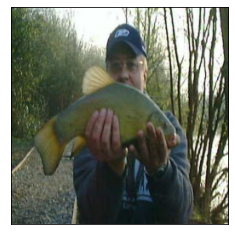

tensor(0)


In [ ]:
inputs,labels=next(iter(train_loader))
inputs = inputs.to(device)
labels = labels.to(device)
prediction = cnn_model(inputs)
# only computer adversarial examples on examples that are originally classified correctly 

imshow(inputs.cpu().data[0])
print(labels.data[0])

**Algorithm to train Adversarial Patch**


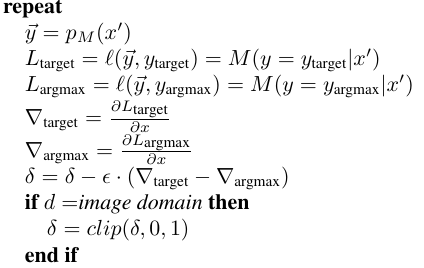


**Function to train Adversarial Patch**

In [ ]:
def attack(x, patch, mask, original, domain='image'):
    cnn_model.eval()

    x_out = F.softmax(cnn_model(x))
    target_prob = x_out.data[0][target]
    
    # Adversarial image
    adv_x = torch.mul((1-mask),x) + torch.mul(mask,patch)
    
    count = 0 
   
    while conf_target > target_prob:
        count += 1
        adv_x = Variable(adv_x.data, requires_grad=True)
        adv_out = cnn_model(adv_x)
       
        #adv_out_probs, adv_out_labels = adv_out.max(1)
        
        # Loss for classifying as target class
        Loss_target = adv_out[0][target]
        # Loss for classifying as original class
        Loss_original = adv_out[0][original]
        # Overall loss
        Loss = Loss_target - Loss_original

        # Backprop loss gradient w.r.t adv_x
        Loss.backward()
        # Gradient calculation
        adv_grad = adv_x.grad.clone()

        # Update patch
        with torch.no_grad():
          patch = patch + adv_grad  
               
        adv_x.grad.data.zero_()   

        # Clipping patch if in image domain (network domain is free to have any values)
        if domain == 'image':
          patch=torch.clamp(patch, 0, 1) 

        clean = torch.mul((1-mask),x)
        pert = torch.mul(mask,patch)
        adv_x = clean + pert
        out = F.softmax(cnn_model(adv_x))
        target_prev=target_prob
        target_prob = out.data[0][target] 
        if ((target_prob-target_prev)< 0.001 or (target_prob<target_prev)):
          break   
        if count >= max_count:
            break
    return adv_x, mask, patch

In [ ]:
# Initialize patch
patch, patch_shape = init_patch_square(image_size, patch_size)
outf = '/content/drive/MyDrive/Colab Notebooks/logs1'

**Training Adversarial Patch**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0
300
600
900
1200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


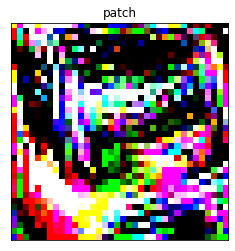

In [ ]:
if train_patch:
  cnn_model.eval()
  success = 0
  nat_total = 0
  adv_total = 0
  recover_time = 0

  for batch_idx, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs, labels = Variable(inputs), Variable(labels)
    prediction = cnn_model(inputs)
    # only computer adversarial examples on examples that are originally classified correctly 
    if prediction.data.max(1)[1][0] != labels.data[0]:
      continue
    nat_total += 1
    input_shape = inputs.data.cpu().numpy().shape
    if patch_type == 'circle':
      patch, mask, patch_shape = circle_transform(patch, input_shape, patch_shape, image_size)
    elif patch_type == 'square':
      patch, mask  = square_transform(patch, input_shape, patch_shape, image_size)
    patch, mask = torch.FloatTensor(patch), torch.FloatTensor(mask)
    patch = patch.to(device)
    mask = mask.to(device)
    patch, mask = Variable(patch), Variable(mask) 
    adv_x, mask, patch = attack(inputs, patch, mask, labels.data[0], domain='network')
    adv_label = cnn_model(adv_x).data.max(1)[1][0]
    ori_label = labels.data[0]
    if adv_label == target:
      success=success+1
      if plot_all == 1: 
        # plot source image
        vutils.save_image(inputs.data, "%s/%d_%d_original.png" %(outf, batch_idx, ori_label), normalize=True)
        
        # plot adversarial image
        vutils.save_image(adv_x.data, "%s/%d_%d_adversarial.png" %(outf, batch_idx, adv_label), normalize=True)

    masked_patch = torch.mul(mask, patch)
    patch = masked_patch.data.cpu().numpy()
    new_patch = np.zeros(patch_shape)
    for i in range(new_patch.shape[0]): 
      for j in range(new_patch.shape[1]): 
        new_patch[i][j] = submatrix(patch[i][j],image_size, patch_size)
    if (batch_idx%300==0):
      print(batch_idx)
    patch = new_patch

imshow(torch.from_numpy(patch[0]),'patch')
f='/content/drive/MyDrive/Colab Notebooks'
vutils.save_image(torch.from_numpy(patch).data, "%s/%d_%d_%d_%s_patch.png" %(f, target, conf_target, patch_size*100, "network"), normalize=True)
#vutils.save_image(torch.clamp(torch.from_numpy(patch),0,1).data, "%s/%d_%d_%d_%s_patch.png" %(f, target, conf_target, patch_size*100, "image"), normalize=True)
pat=torch.from_numpy(patch).data  
  

**Load trained patch**

In [ ]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/8_0_2_image_patch.png")
convert_tensor = transforms.ToTensor()
pat = convert_tensor(img)
pat=pat[None,:]

**Testing trained patch**

In [ ]:
# Test
total=1000
clean_total=0
target_total=0
untarget_total=0
for batch_idx, (inputs, labels) in enumerate(val_loader):
  inputs = inputs.to(device)
  labels = labels.to(device)
  inputs, labels = Variable(inputs), Variable(labels)
  prediction = cnn_model(inputs)
  if prediction.data.max(1)[1][0] != labels.data[0]:
    continue
  clean_total=clean_total+1
  input_shape = inputs.data.cpu().numpy().shape
  patch, mask = test_transform(pat, input_shape, patch_shape, image_size)
  patch, mask = torch.FloatTensor(patch), torch.FloatTensor(mask)
  patch = patch.to(device)
  mask = mask.to(device)
  adv_input = torch.mul((1-mask),inputs) + torch.mul(mask,patch)
  patch, mask = Variable(patch), Variable(mask) 
  adv_label = cnn_model(adv_input).data.max(1)[1]
  ori_label = labels.data[0]
  if adv_label[0] != labels.data[0]:
    if adv_label[0]==target:
      target_total=target_total+1
    else:
      untarget_total=untarget_total+1

print("Clean Accuracy")
print((clean_total*100)/total)
print("Adversarial Accuracy")
print((1-((target_total+untarget_total)/total))*100)

Clean Accuracy
86.3
Adversarial Accuracy
19.699999999999996


# Experiment 

Heat map of Probabilities of source and target class for attacked image with patch on each location on the image

**Load image to be attacked**

In [ ]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/Imagenette/Truck.JPEG")
image=transform(img)
image=image[None,:]

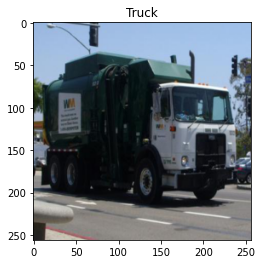

In [ ]:
imshow(image.data[0], 'Truck')

**Load patch to attack**

In [ ]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/8_0_2_image_patch.png")
convert_tensor = transforms.ToTensor()
pat = convert_tensor(img)
pat=pat[None,:]

# Dimension of image and patch
i_dim=image.shape[-1]
p_dim=pat.shape[-1]

**Applying patch on fixed corner of the image**

In [ ]:
source=6
target=8
h_map=i_dim-p_dim
dim=int(i_dim/p_dim)
source_map=torch.zeros(h_map,h_map)
target_map=torch.zeros(h_map,h_map)

image_shape = image.data.cpu().numpy().shape
i=0
while (i < h_map):
  j=0
  while(j < h_map):
    patch = np.zeros(image_shape)
    mask = np.zeros(image_shape)
  
    # x-location  
    random_x = i
    # y-ocation
    random_y = j
  
    # apply patch to dummy image  
    patch[0][0][random_x:random_x+p_dim, random_y:random_y+p_dim] = pat[0][0]
    patch[0][1][random_x:random_x+p_dim, random_y:random_y+p_dim] = pat[0][1]
    patch[0][2][random_x:random_x+p_dim, random_y:random_y+p_dim] = pat[0][2]
    
    # apply patch to dummy image  
    mask[0][0][random_x:random_x+p_dim, random_y:random_y+p_dim] = 1
    mask[0][1][random_x:random_x+p_dim, random_y:random_y+p_dim] = 1
    mask[0][2][random_x:random_x+p_dim, random_y:random_y+p_dim] = 1

    patch, mask = torch.FloatTensor(patch), torch.FloatTensor(mask)
    patch = patch.to(device)
    mask = mask.to(device)
    adv_input = torch.mul((1-mask),inputs) + torch.mul(mask,patch)
    patch, mask = Variable(patch), Variable(mask)
    vec=cnn_model(adv_input).data
    m = nn.Softmax(dim=0)
    prob = m(vec[0])
    for p in range(int(p_dim/8)):
      for q in range(int(p_dim/8)):
        source_map[i+p][j+q]=prob[source]
        target_map[i+p][j+q]=prob[target]

    j=j+int(p_dim/8)
  i=i+int(p_dim/8)
s_map=source_map.numpy()
t_map=target_map.numpy()

**Visualization of heatmap map of source and target class probability**

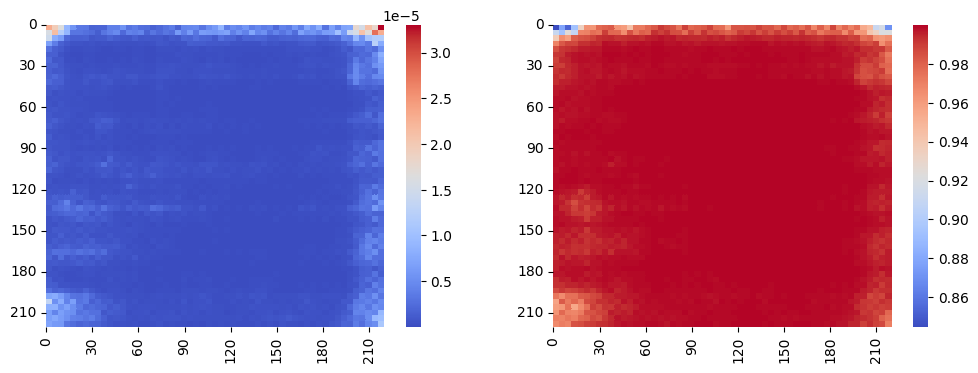

In [ ]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4), dpi=100)

g1 = sns.heatmap(s_map,cmap="coolwarm",cbar=True,ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_xticks([  0,  30,  60,  90, 120, 150, 180, 210])
g1.set_yticks([  0,  30,  60,  90, 120, 150, 180, 210])
g1.set_xticklabels([  0,  30,  60,  90, 120, 150, 180, 210])
g1.set_yticklabels([  0,  30,  60,  90, 120, 150, 180, 210])

g2 = sns.heatmap(t_map,cmap="coolwarm",cbar=True,ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_xticks([  0,  30,  60,  90, 120, 150, 180, 210])
g2.set_yticks([  0,  30,  60,  90, 120, 150, 180, 210])
g2.set_xticklabels([  0,  30,  60,  90, 120, 150, 180, 210])
g2.set_yticklabels([  0,  30,  60,  90, 120, 150, 180, 210])
plt.show()

# Experiment 4

Saliency map of original and attacked image

**Function to find saliency map**

In [ ]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/Imagenette/Parachute.JPEG")
image=transform(img)
image=image[None,:]

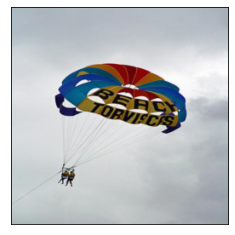

In [ ]:
imshow(image.data[0])

In [ ]:
vutils.save_image(image.data, "/content/drive/MyDrive/Colab Notebooks/trench_ori.png", normalize=True)

**Load patch to attack**

In [ ]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/Patch/0_0_2_image_patch.png")
convert_tensor = transforms.ToTensor()
pat = convert_tensor(img)
pat=pat[None,:]

# Dimension of image and patch
i_dim=image.shape[-1]
p_dim=pat.shape[-1]

**Applying patch on fixed corner of the image**

In [ ]:
input_shape = image.data.cpu().numpy().shape
patch, mask = test_transform(pat, input_shape, patch_shape, image_size)
patch, mask = torch.FloatTensor(patch), torch.FloatTensor(mask)
patch = patch.to(device)
mask = mask.to(device)
adv_input = torch.mul((1-mask),image) + torch.mul(mask,patch)
patch, mask = Variable(patch), Variable(mask) 
adv_label = cnn_model(adv_input).data.max(1)[1]

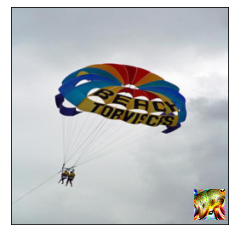

In [ ]:
imshow(adv_input.data[0])

In [ ]:
vutils.save_image(adv_input.data, "/content/drive/MyDrive/Colab Notebooks/trench_adv.png", normalize=True)

In [ ]:
#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    normalize,          
])

In [ ]:
def saliency(img, model, PATH):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transf(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    #slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.colorbar(fraction=0.046)
    plt.xticks([])  
    plt.yticks([])
    plt.savefig(PATH)
    plt.show()

**Saliency map of original image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


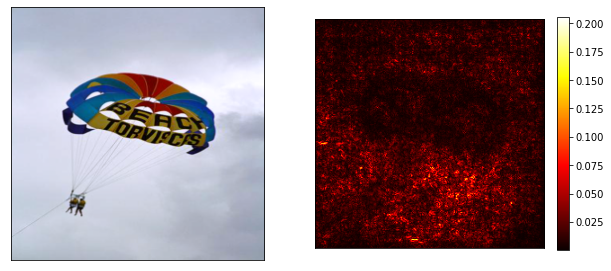

In [ ]:
img = Image.open('/content/drive/MyDrive/Colab Notebooks/trench_ori.png')
saliency(img, cnn_model.to('cpu'), '/content/drive/MyDrive/Colab Notebooks/golf_sm_ori.png')

**Salinecy map of adversarial image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


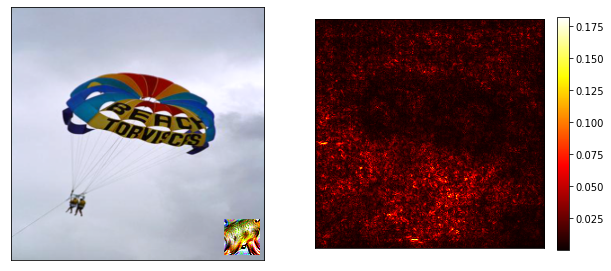

In [ ]:
img = Image.open('/content/drive/MyDrive/Colab Notebooks/trench_adv.png')
saliency(img, cnn_model.to('cpu'), '/content/drive/MyDrive/Colab Notebooks/golf_sm_adv.png')

# Experiment 5

Transferability across images


In [ ]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/Imagenette/Dog.JPEG")
image=transform(img)
image=image[None,:]

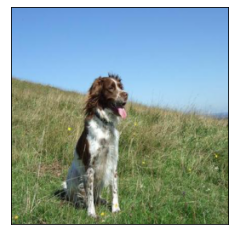

In [ ]:
imshow(image.data[0])

**Load patch to attack**

In [ ]:
img = Image.open("/content/drive/MyDrive/Colab Notebooks/Patch/0_0_2_image_patch.png")
convert_tensor = transforms.ToTensor()
pat = convert_tensor(img)
pat=pat[None,:]

# Dimension of image and patch
i_dim=image.shape[-1]
p_dim=pat.shape[-1]

**Applying patch on fixed corner of the image**

In [ ]:
m = nn.Softmax(dim=0)
input_shape = image.data.cpu().numpy().shape
ori_pred = m(cnn_model(image)[0])*100

patch, mask = test_transform(pat, input_shape, patch_shape, image_size)
patch, mask = torch.FloatTensor(patch), torch.FloatTensor(mask)
patch = patch.to(device)
mask = mask.to(device)
adv_input = torch.mul((1-mask),image) + torch.mul(mask,patch)
patch, mask = Variable(patch), Variable(mask)

adv_pred = m(cnn_model(adv_input)[0])*100

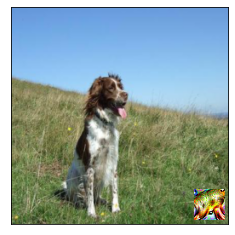

In [ ]:
imshow(adv_input.data[0])

In [ ]:
adv_pred.int()

tensor([85,  3,  0,  0,  0,  0,  0,  0,  3,  4], dtype=torch.int32)

In [ ]:
ori_pred.int()

tensor([ 1, 76,  0,  0,  0,  0,  0,  0,  7, 11], dtype=torch.int32)